# Phase 1: Flow Matching Fundamentals

In this notebook, we build a generative model for MNIST digits using **flow matching** - a clean and intuitive approach to learning generative models.

## The Goal of Generative Modeling

We want to learn to generate new data samples that look like our training data. Mathematically:

- We have training data $x \sim p_{\text{data}}(x)$ (e.g., real MNIST digits)
- We want to sample from $p_{\text{data}}$ even though we don't know its explicit form

The strategy: learn to **transform** samples from a simple distribution (Gaussian noise) into samples from the complex data distribution.

## Why Flow Matching?

There are several approaches to generative modeling:

| Approach | Key Idea | Complexity |
|----------|----------|------------|
| **GANs** | Adversarial game between generator and discriminator | Training instability |
| **VAEs** | Encode to latent space, decode back | Blurry outputs |
| **DDPM** | Add noise gradually, learn to reverse it | Stochastic, many steps |
| **Flow Matching** | Learn straight paths from noise to data | Simple, deterministic |

Flow matching has gained popularity because:
1. **Simpler mathematics** than DDPM (no stochastic differential equations)
2. **Faster sampling** (straight paths are more efficient)
3. **Same training objective** works for any architecture
4. **State-of-the-art results** (used in Stable Diffusion 3, etc.)

## The Mathematical Framework

### The Core Idea: Probability Paths

Imagine we have two distributions:
- $p_0$: The data distribution (complex, unknown) - what we want to sample from
- $p_1$: A simple distribution (standard Gaussian) - easy to sample from

Flow matching constructs a **continuous path of distributions** $p_t$ that smoothly transitions from $p_0$ to $p_1$ as $t$ goes from 0 to 1:

$$p_0 \xrightarrow{t=0 \to 1} p_1$$

If we can describe how individual samples move along this path, we can:
1. **Train**: Learn the "velocity" of samples at each point
2. **Generate**: Start from $p_1$ (noise) and follow velocities backward to $p_0$ (data)

### The Probability Path via Interpolation

The simplest way to construct this path is **linear interpolation**. For a data point $x_0$ and a noise sample $x_1$:

$$x_t = (1-t) \cdot x_0 + t \cdot x_1$$

This traces a straight line in pixel space from $x_0$ (at $t=0$) to $x_1$ (at $t=1$).

**Intuition**: At $t=0$, we have the clean image. At $t=1$, we have pure noise. At $t=0.5$, we have a 50-50 blend.

### The Velocity Field

The **velocity** tells us how $x_t$ changes as $t$ increases. Taking the derivative:

$$v = \frac{dx_t}{dt} = \frac{d}{dt}\left[(1-t) \cdot x_0 + t \cdot x_1\right] = -x_0 + x_1 = x_1 - x_0$$

**Key insight**: The velocity is **constant** along the path! It doesn't depend on $t$. This means:
- Each point travels in a straight line
- The velocity is simply the direction from data to noise

### The Neural Network's Job

We train a neural network $v_\theta(x_t, t)$ to predict this velocity given:
- $x_t$: The current (noised) sample
- $t$: The current timestep

The training loss is simple **mean squared error**:

$$\mathcal{L} = \mathbb{E}_{x_0, x_1, t}\left[\|v_\theta(x_t, t) - (x_1 - x_0)\|^2\right]$$

### Generating Samples (The ODE)

Once trained, we generate samples by solving an **ordinary differential equation** (ODE):

$$\frac{dx_t}{dt} = v_\theta(x_t, t)$$

We start at $t=1$ with noise $x_1 \sim \mathcal{N}(0, I)$ and integrate backward to $t=0$:

$$x_0 = x_1 - \int_1^0 v_\theta(x_t, t) \, dt$$

In practice, we use **Euler integration**:

$$x_{t-\Delta t} = x_t - \Delta t \cdot v_\theta(x_t, t)$$

Repeat for many small steps from $t=1$ to $t=0$.

### Summary of Key Equations

| Concept | Equation | Description |
|---------|----------|-------------|
| **Interpolation** | $x_t = (1-t)x_0 + tx_1$ | Straight path from data to noise |
| **Velocity** | $v = x_1 - x_0$ | Constant direction along path |
| **Training Loss** | $\mathcal{L} = \|v_\theta(x_t, t) - v\|^2$ | MSE between predicted and true velocity |
| **Sampling ODE** | $\frac{dx}{dt} = v_\theta(x, t)$ | Follow velocity field backward |
| **Euler Step** | $x_{t-\Delta t} = x_t - \Delta t \cdot v_\theta$ | Discrete approximation |

Now let's implement this!

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Auto-reload modules during development
%load_ext autoreload
%autoreload 2

# Set up device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## 1. The Data Distribution: MNIST

We use MNIST (28×28 grayscale handwritten digits) as our target distribution $p_{\text{data}}$.

MNIST is ideal for learning because:
- Small images = fast training
- Simple structure = easy to verify results visually
- Yet complex enough to be interesting (10 digit classes, varying styles)

**Preprocessing**: We normalize pixel values to $[-1, 1]$ (instead of $[0, 1]$) so they're centered around zero, matching the Gaussian noise distribution we'll use.

In [5]:
# Transform: convert to tensor and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Maps [0,1] to [-1,1]
])

# Download and load MNIST
train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,  # Set to 0 for MPS compatibility
    drop_last=True
)

print(f"Dataset size: {len(train_dataset):,} images")
print(f"Batches per epoch: {len(train_loader)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Pixel range: [{train_dataset[0][0].min():.1f}, {train_dataset[0][0].max():.1f}]")

Dataset size: 60,000 images
Batches per epoch: 468
Image shape: torch.Size([1, 28, 28])
Pixel range: [-1.0, 1.0]


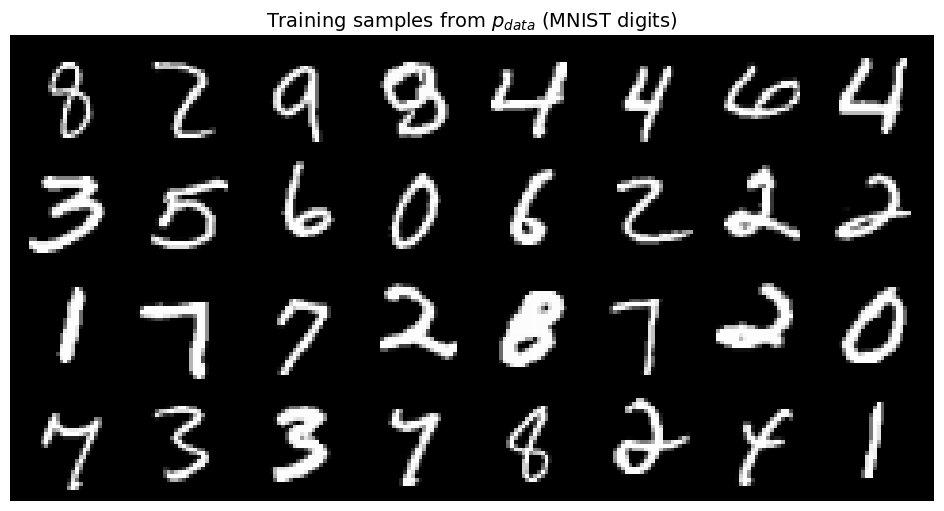

In [6]:
# Visualize some training samples
def show_images(images, nrow=8, title=""):
    """Display a grid of images."""
    # Denormalize from [-1, 1] to [0, 1]
    images = (images + 1) / 2
    images = images.clamp(0, 1)
    
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(12, 12 * grid.shape[1] / grid.shape[2]))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14)
    plt.show()

# Get a batch and visualize
sample_batch, _ = next(iter(train_loader))
show_images(sample_batch[:32], title="Training samples from $p_{data}$ (MNIST digits)")

## 2. The Forward Process: Data → Noise

Now let's implement and visualize the interpolation path from data to noise.

### Mathematical Recap

For a data point $x_0$ and noise sample $x_1 \sim \mathcal{N}(0, I)$:

$$x_t = (1-t) \cdot x_0 + t \cdot x_1$$

At different timesteps:
- $t = 0$: $x_0$ (pure data)
- $t = 0.5$: $0.5 \cdot x_0 + 0.5 \cdot x_1$ (half data, half noise)
- $t = 1$: $x_1$ (pure noise)

### Geometric Interpretation

Think of the 784-dimensional space (28×28 pixels) where each image is a point:
- $x_0$ is a point in the "data manifold" (where real digits live)
- $x_1$ is a random point (Gaussian noise, spread throughout space)
- $x_t$ traces a straight line between them

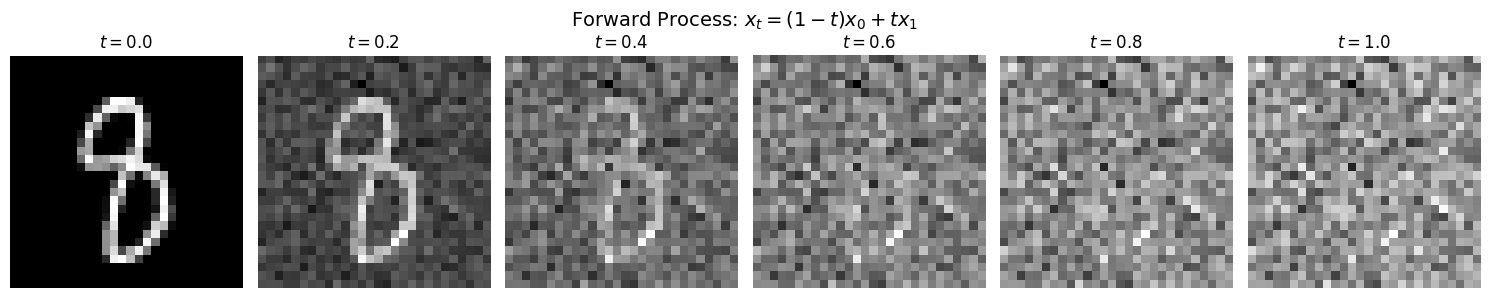


Observe how the digit structure gradually dissolves into noise.
The model will learn to reverse this process.


In [7]:
from text_to_image.flow import FlowMatching

flow = FlowMatching()

# Take one image and show its path to noise
x_0 = sample_batch[0:1]  # Shape: (1, 1, 28, 28)
x_1 = torch.randn_like(x_0)  # Sample noise ~ N(0, I)

# Show interpolation at different timesteps
timesteps = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
interpolated = []

for t in timesteps:
    t_tensor = torch.tensor([t])
    x_t, velocity = flow.forward_process(x_0, x_1, t_tensor)
    interpolated.append(x_t)

# Visualize
fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 3))
for i, (ax, t) in enumerate(zip(axes, timesteps)):
    img = (interpolated[i][0, 0] + 1) / 2  # Denormalize
    ax.imshow(img.numpy(), cmap='gray')
    ax.set_title(f'$t = {t}$', fontsize=12)
    ax.axis('off')
    
    # Add equation annotation
    if t == 0.0:
        ax.set_xlabel('$x_0$ (data)', fontsize=10)
    elif t == 1.0:
        ax.set_xlabel('$x_1$ (noise)', fontsize=10)
    elif t == 0.5:
        ax.set_xlabel('$0.5 x_0 + 0.5 x_1$', fontsize=10)

plt.suptitle('Forward Process: $x_t = (1-t) x_0 + t x_1$', fontsize=14)
plt.tight_layout()
plt.show()

print("\nObserve how the digit structure gradually dissolves into noise.")
print("The model will learn to reverse this process.")

## 3. The Velocity Field

### Mathematical Derivation

The velocity is the time derivative of the interpolation:

$$v = \frac{dx_t}{dt} = \frac{d}{dt}\left[(1-t) x_0 + t x_1\right]$$

Using the product rule:
$$v = -x_0 + x_1 = x_1 - x_0$$

**Key property**: The velocity is **independent of $t$**! This means:
1. Each sample travels at constant velocity
2. Paths are perfectly straight lines
3. The velocity equals the displacement from data to noise

### What Does the Velocity Look Like?

Since $v = x_1 - x_0$:
- Where $x_1 > x_0$ (noise brighter than data): velocity is positive (pixel gets brighter)
- Where $x_1 < x_0$ (noise darker than data): velocity is negative (pixel gets darker)
- The velocity essentially "encodes" how to transform this specific data point into this specific noise

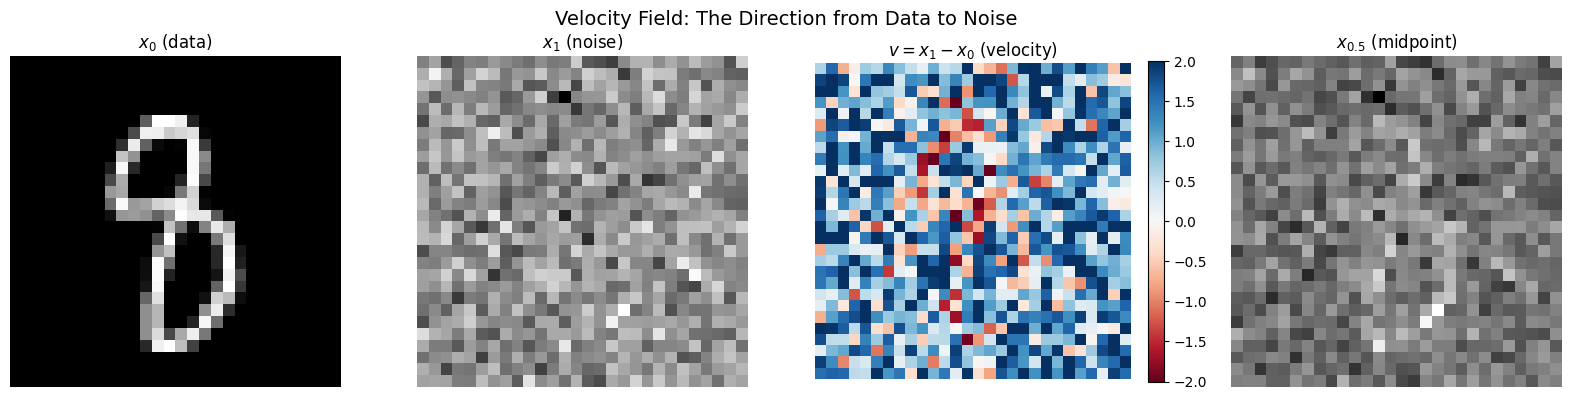


Velocity field interpretation:
• Red regions: noise is brighter than data (positive velocity)
• Blue regions: noise is darker than data (negative velocity)
• White regions: similar values (near-zero velocity)


In [8]:
# Compute and visualize the velocity field for a single example
t_tensor = torch.tensor([0.5])  # Timestep doesn't matter for velocity!
x_t, velocity = flow.forward_process(x_0, x_1, t_tensor)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Data point x_0
axes[0].imshow((x_0[0, 0] + 1) / 2, cmap='gray')
axes[0].set_title('$x_0$ (data)', fontsize=12)
axes[0].axis('off')

# Noise point x_1
axes[1].imshow((x_1[0, 0] + 1) / 2, cmap='gray')
axes[1].set_title('$x_1$ (noise)', fontsize=12)
axes[1].axis('off')

# Velocity v = x_1 - x_0
v_display = velocity[0, 0].numpy()
im = axes[2].imshow(v_display, cmap='RdBu', vmin=-2, vmax=2)
axes[2].set_title('$v = x_1 - x_0$ (velocity)', fontsize=12)
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], fraction=0.046)

# Interpolated sample at t=0.5
axes[3].imshow((x_t[0, 0] + 1) / 2, cmap='gray')
axes[3].set_title('$x_{0.5}$ (midpoint)', fontsize=12)
axes[3].axis('off')

plt.suptitle('Velocity Field: The Direction from Data to Noise', fontsize=14)
plt.tight_layout()
plt.show()

print("\nVelocity field interpretation:")
print("• Red regions: noise is brighter than data (positive velocity)")
print("• Blue regions: noise is darker than data (negative velocity)")
print("• White regions: similar values (near-zero velocity)")

In [9]:
# Verify: velocity is constant at all timesteps
print("Verifying velocity is constant along the path...")
print()

for t in [0.0, 0.25, 0.5, 0.75, 1.0]:
    t_tensor = torch.tensor([t])
    _, v = flow.forward_process(x_0, x_1, t_tensor)
    v_norm = torch.norm(v).item()
    print(f"t = {t:.2f}: ||v|| = {v_norm:.4f}")

print()
print("✓ The velocity norm is identical at all timesteps!")
print("  This confirms v = x₁ - x₀ is constant (independent of t).")

Verifying velocity is constant along the path...

t = 0.00: ||v|| = 40.3449
t = 0.25: ||v|| = 40.3449
t = 0.50: ||v|| = 40.3449
t = 0.75: ||v|| = 40.3449
t = 1.00: ||v|| = 40.3449

✓ The velocity norm is identical at all timesteps!
  This confirms v = x₁ - x₀ is constant (independent of t).


## 4. The Neural Network Architecture

We need a neural network $v_\theta(x_t, t)$ that takes:
- $x_t$: The noised image (28×28×1)
- $t$: The timestep (scalar in [0, 1])

And predicts the velocity field $v$ (same shape as $x_t$).

### U-Net Architecture

We use a **U-Net**, a classic architecture for image-to-image tasks:

```
Input (28×28) ──┐                      ┌── Output (28×28)
                ▼                      ▲
            [Encoder]              [Decoder]
                │                      │
           downsample              upsample
                │                      │
                ▼                      ▲
            (14×14)    ──────────>  (14×14)  ← skip connection
                │                      │
           downsample              upsample
                │                      │
                ▼                      ▲
             (7×7)     ──────────>   (7×7)   ← skip connection
                │                      │
                └─────> bottleneck ────┘
```

**Skip connections** allow fine details to flow directly to the output.

### Timestep Conditioning

The network needs to know the current timestep $t$ to predict the appropriate velocity. We use **sinusoidal positional encoding** (from the Transformer paper):

$$\text{emb}(t) = \left[\sin(\omega_1 t), \cos(\omega_1 t), \sin(\omega_2 t), \cos(\omega_2 t), \ldots\right]$$

where $\omega_i$ are different frequencies. This rich embedding is then added to the network's feature maps at each layer.

In [10]:
from text_to_image.models import SimpleUNet

model = SimpleUNet(
    in_channels=1,       # Grayscale images
    model_channels=64,   # Base channel count (doubled at each level)
    time_emb_dim=128,    # Timestep embedding dimension
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params:,}")
print(f"\nThis is a relatively small model - larger models give better results.")

# Test forward pass
test_x = torch.randn(4, 1, 28, 28, device=device)
test_t = torch.rand(4, device=device)

with torch.no_grad():
    test_out = model(test_x, test_t)

print(f"\nForward pass test:")
print(f"  Input shape:  {test_x.shape}  (batch, channels, height, width)")
print(f"  Timestep:     {test_t.shape}  (batch,)")
print(f"  Output shape: {test_out.shape}  (same as input - predicts velocity at each pixel)")

Model parameters: 1,837,185

This is a relatively small model - larger models give better results.

Forward pass test:
  Input shape:  torch.Size([4, 1, 28, 28])  (batch, channels, height, width)
  Timestep:     torch.Size([4])  (batch,)
  Output shape: torch.Size([4, 1, 28, 28])  (same as input - predicts velocity at each pixel)


## 5. Training: Learning the Velocity Field

### The Training Algorithm

For each training step:

1. **Sample data**: $x_0 \sim p_{\text{data}}$ (a batch of real digits)
2. **Sample noise**: $x_1 \sim \mathcal{N}(0, I)$ (same shape as $x_0$)
3. **Sample timestep**: $t \sim \text{Uniform}[0, 1]$
4. **Compute interpolation**: $x_t = (1-t) x_0 + t x_1$
5. **Compute true velocity**: $v = x_1 - x_0$
6. **Predict velocity**: $\hat{v} = v_\theta(x_t, t)$
7. **Compute loss**: $\mathcal{L} = \|\hat{v} - v\|^2$ (MSE)
8. **Update weights**: Backpropagation and gradient descent

### Why Does This Work?

The model sees many $(x_t, t) \to v$ examples:
- Different data points $x_0$
- Different noise samples $x_1$  
- Different timesteps $t$

It learns to recognize patterns:
- "At $t \approx 1$ (mostly noise), the velocity points toward structure"
- "At $t \approx 0$ (mostly data), the velocity is small adjustments"

The key insight: by learning the **conditional expectation** of velocity given $x_t$ and $t$, the model implicitly learns the marginal distribution $p_t$ at each timestep.

In [11]:
from text_to_image.train import Trainer

# Create trainer
trainer = Trainer(
    model=model,
    dataloader=train_loader,
    lr=1e-4,          # Learning rate
    weight_decay=0.01, # Regularization
    device=device,
)

# Train
NUM_EPOCHS = 30  # Increase to 50+ for better quality

print("Training the velocity prediction network...")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Batches per epoch: {len(train_loader)}")
print()

losses = trainer.train(num_epochs=NUM_EPOCHS)

Training the velocity prediction network...
Epochs: 30
Batch size: 128
Batches per epoch: 468

Training on cuda
Model parameters: 1,837,185


Epoch 1/30: 100%|█████████████████████| 468/468 [00:17<00:00, 26.26it/s, loss=0.2318]


Epoch 1: avg_loss = 0.3411


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.58it/s, loss=0.2214]


Epoch 2: avg_loss = 0.2287


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.56it/s, loss=0.2051]


Epoch 3: avg_loss = 0.2129


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.58it/s, loss=0.2109]


Epoch 4: avg_loss = 0.2060


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.54it/s, loss=0.2089]


Epoch 5: avg_loss = 0.1995


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.52it/s, loss=0.1938]


Epoch 6: avg_loss = 0.1951


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.52it/s, loss=0.2003]


Epoch 7: avg_loss = 0.1934


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.55it/s, loss=0.2059]


Epoch 8: avg_loss = 0.1910


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.50it/s, loss=0.2028]


Epoch 9: avg_loss = 0.1886


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.51it/s, loss=0.1793]


Epoch 10: avg_loss = 0.1866


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.47it/s, loss=0.1867]


Epoch 11: avg_loss = 0.1853


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.46it/s, loss=0.1723]


Epoch 12: avg_loss = 0.1832


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.49it/s, loss=0.1851]


Epoch 13: avg_loss = 0.1830


Epoch 14/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.51it/s, loss=0.1802]


Epoch 14: avg_loss = 0.1818


Epoch 15/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.50it/s, loss=0.1718]


Epoch 15: avg_loss = 0.1808


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.43it/s, loss=0.1805]


Epoch 16: avg_loss = 0.1801


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.38it/s, loss=0.1680]


Epoch 17: avg_loss = 0.1791


Epoch 18/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.45it/s, loss=0.1886]


Epoch 18: avg_loss = 0.1791


Epoch 19/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.44it/s, loss=0.1762]


Epoch 19: avg_loss = 0.1781


Epoch 20/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.50it/s, loss=0.1862]


Epoch 20: avg_loss = 0.1774


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.46it/s, loss=0.1780]


Epoch 21: avg_loss = 0.1769


Epoch 22/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.44it/s, loss=0.1564]


Epoch 22: avg_loss = 0.1769


Epoch 23/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.39it/s, loss=0.1748]


Epoch 23: avg_loss = 0.1767


Epoch 24/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.49it/s, loss=0.1745]


Epoch 24: avg_loss = 0.1753


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.38it/s, loss=0.1715]


Epoch 25: avg_loss = 0.1760


Epoch 26/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.44it/s, loss=0.1582]


Epoch 26: avg_loss = 0.1750


Epoch 27/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.45it/s, loss=0.1762]


Epoch 27: avg_loss = 0.1745


Epoch 28/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.49it/s, loss=0.1734]


Epoch 28: avg_loss = 0.1750


Epoch 29/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.49it/s, loss=0.1732]


Epoch 29: avg_loss = 0.1746


Epoch 30/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.53it/s, loss=0.1634]

Epoch 30: avg_loss = 0.1745


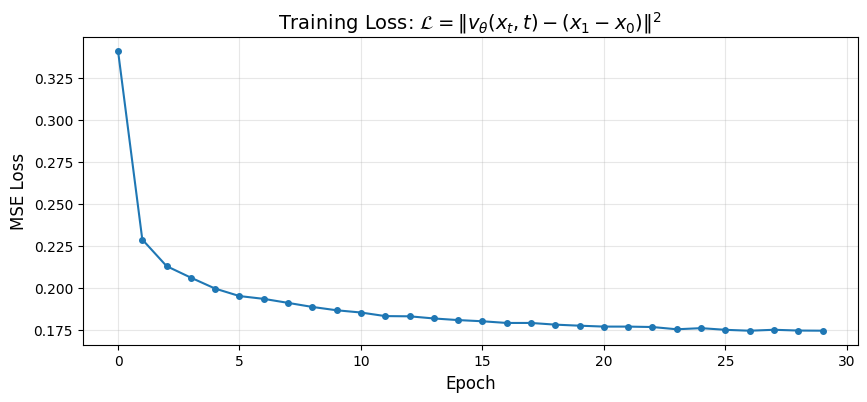

Final loss: 0.1745

Lower loss = model better predicts the velocity field.


In [12]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses, marker='o', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title(r'Training Loss: $\mathcal{L} = \|v_\theta(x_t, t) - (x_1 - x_0)\|^2$', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {losses[-1]:.4f}")
print("\nLower loss = model better predicts the velocity field.")

## 6. Sampling: Generating New Images

Now for the exciting part - using our trained model to generate new digits!

### The Sampling ODE

We solve the ODE:
$$\frac{dx}{dt} = v_\theta(x, t)$$

**Starting point**: $x_1 \sim \mathcal{N}(0, I)$ (random noise at $t=1$)

**Goal**: Integrate backward to $t=0$ to get a sample from $p_{\text{data}}$

### Euler Integration

We discretize time into $N$ steps and use the Euler method:

$$x_{t - \Delta t} = x_t - \Delta t \cdot v_\theta(x_t, t)$$

where $\Delta t = 1/N$.

**Intuition**: At each step, we:
1. Ask the model: "What velocity should this sample have?"
2. Move in the opposite direction (since we're going backward in time)
3. Repeat until we reach $t=0$

### Why Backward?

During training, the velocity field points from data to noise ($x_1 - x_0$).

During sampling, we want to go from noise to data, so we:
- Start at $t=1$ (noise)
- Subtract the velocity (go opposite direction)
- End at $t=0$ (data)

Generating 64 new digits from random noise...
(Starting at t=1, integrating backward to t=0)



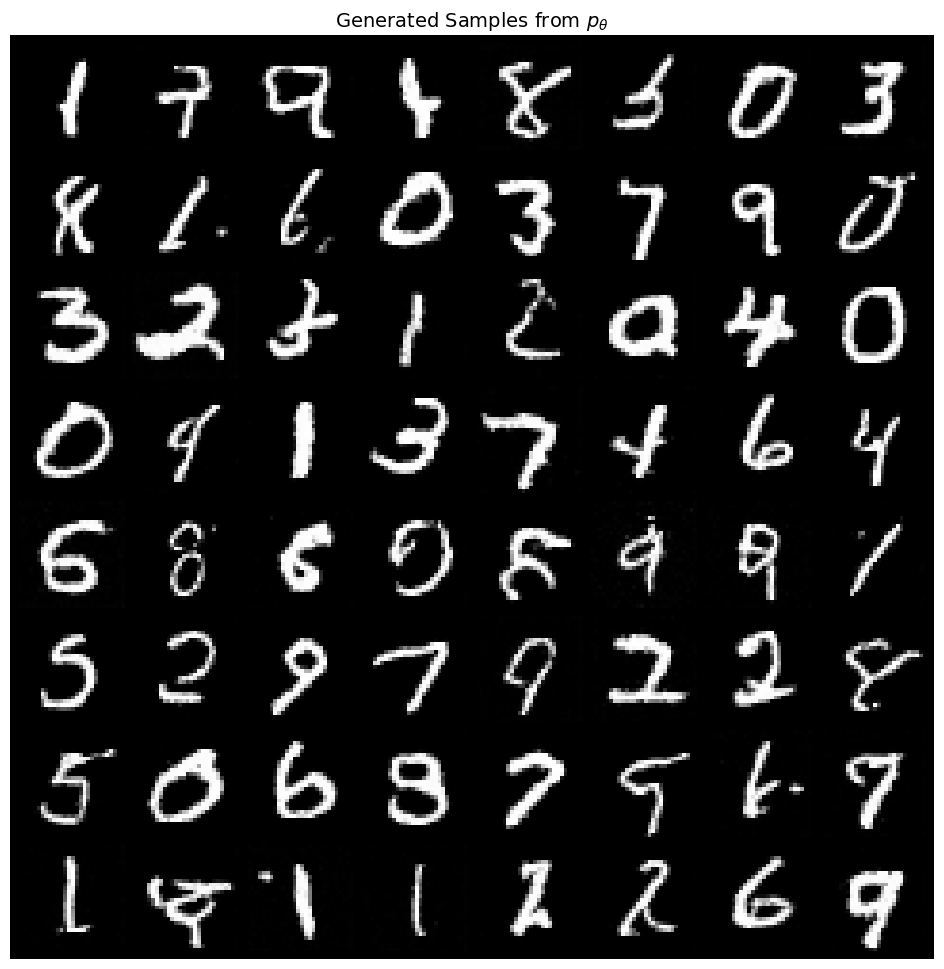

In [13]:
from text_to_image.sampling import sample

# Generate samples
model.eval()

print("Generating 64 new digits from random noise...")
print("(Starting at t=1, integrating backward to t=0)")
print()

with torch.no_grad():
    generated, trajectory = sample(
        model=model,
        num_samples=64,
        image_shape=(1, 28, 28),
        num_steps=50,      # Number of Euler steps
        device=device,
        return_trajectory=True,
    )

show_images(generated, nrow=8, title="Generated Samples from $p_{\\theta}$")

## 7. Visualizing the Generation Process

Let's watch how noise transforms into digits step by step.

This visualization shows the ODE integration:
- $t=1.00$: Pure noise $x_1 \sim \mathcal{N}(0, I)$
- $t \to 0$: Following $-v_\theta(x, t)$ backward
- $t=0.00$: Generated digit

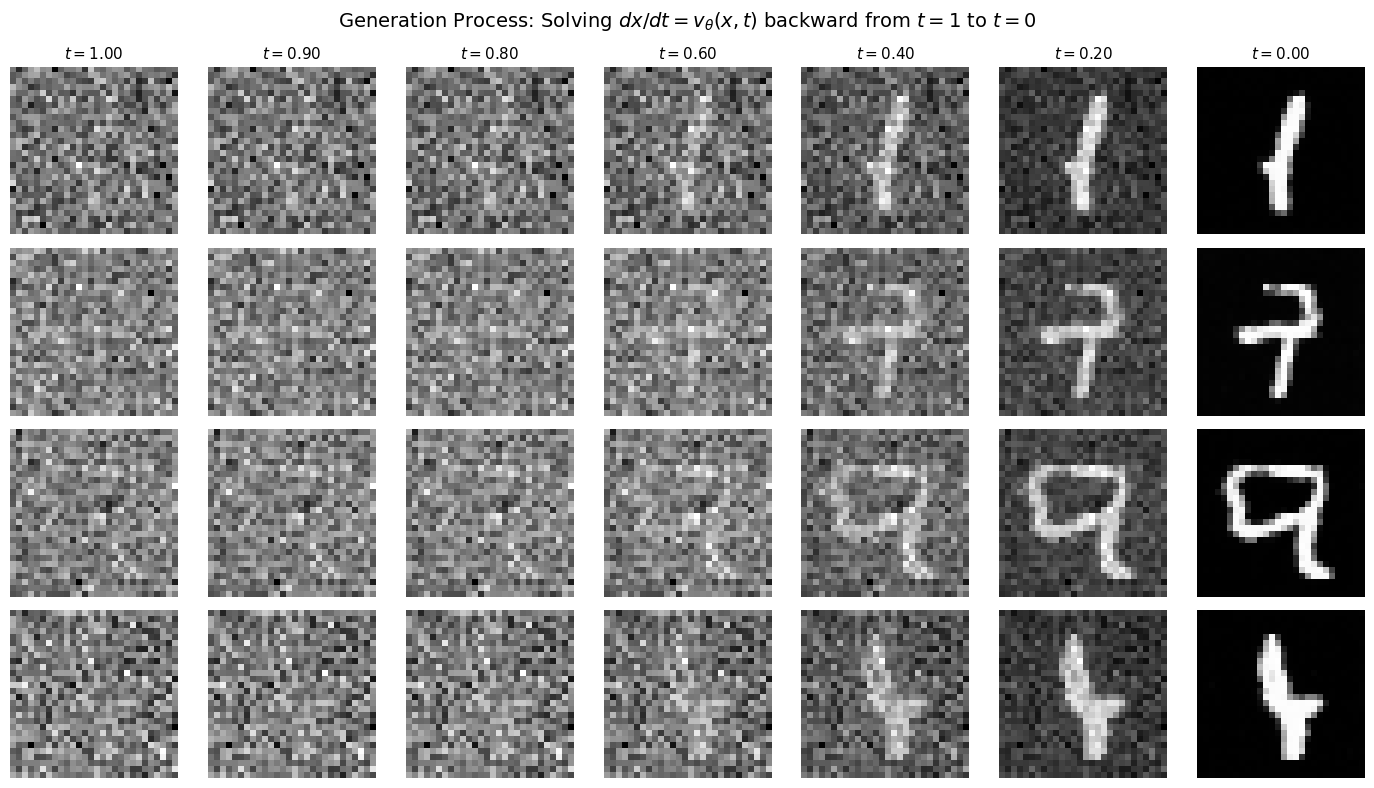


Observe how structure emerges:
• t≈1: Random noise
• t≈0.7: Large-scale structure appears (rough digit shape)
• t≈0.3: Details emerge (strokes, curves)
• t=0: Final digit


In [14]:
# Show the trajectory for a few samples
num_to_show = 4
steps_to_show = [0, 5, 10, 20, 30, 40, 50]  # Which steps to visualize

fig, axes = plt.subplots(num_to_show, len(steps_to_show), figsize=(14, 8))

for row in range(num_to_show):
    for col, step_idx in enumerate(steps_to_show):
        img = trajectory[step_idx][row, 0]
        img = (img + 1) / 2  # Denormalize
        axes[row, col].imshow(img.cpu().numpy(), cmap='gray')
        axes[row, col].axis('off')
        if row == 0:
            t_val = 1.0 - step_idx / 50
            axes[row, col].set_title(f'$t={t_val:.2f}$', fontsize=11)

plt.suptitle('Generation Process: Solving $dx/dt = v_\\theta(x, t)$ backward from $t=1$ to $t=0$', fontsize=14)
plt.tight_layout()
plt.show()

print("\nObserve how structure emerges:")
print("• t≈1: Random noise")
print("• t≈0.7: Large-scale structure appears (rough digit shape)")
print("• t≈0.3: Details emerge (strokes, curves)")
print("• t=0: Final digit")

## 8. Analyzing What the Model Learned

Let's verify our model learned meaningful velocity predictions.

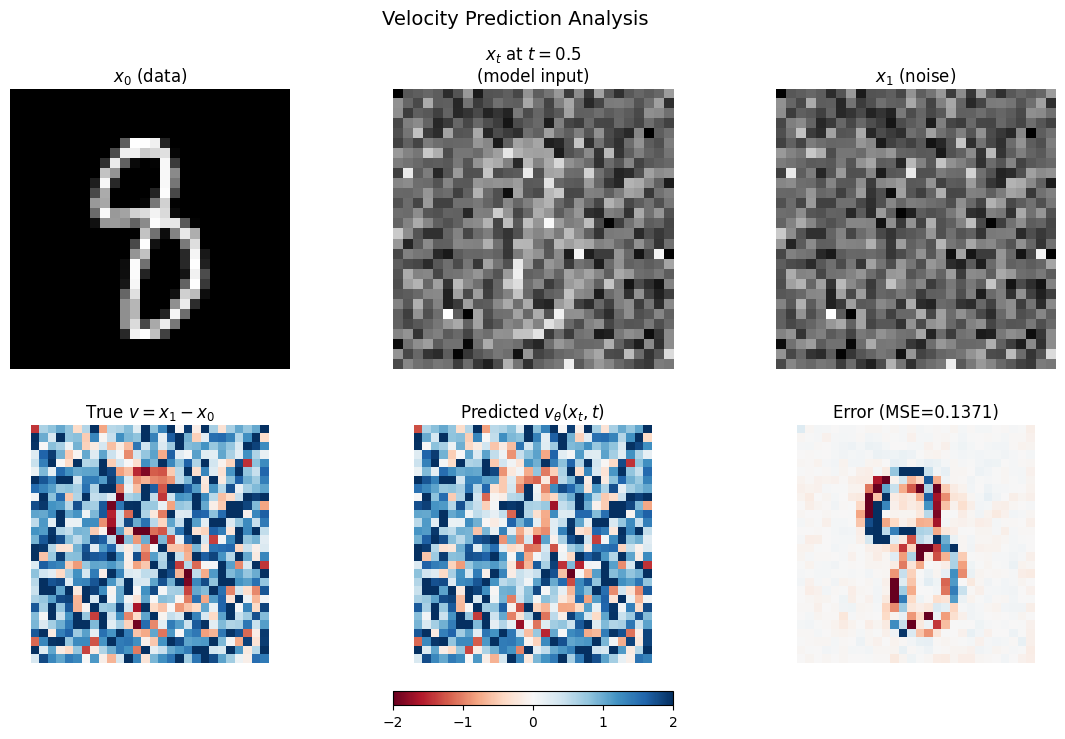


Note: The model sees only x_t and t, but must predict v = x_1 - x_0.
It can't know the exact x_1 used, so it predicts the expected velocity.
The prediction captures the overall structure even if not pixel-perfect.


In [17]:
# Compare predicted vs true velocity
x_0 = sample_batch[0:1].to(device)
x_1 = torch.randn_like(x_0)
t = torch.tensor([0.5], device=device)

# True velocity
true_v = x_1 - x_0

# Interpolated sample
x_t = (1 - t.view(-1, 1, 1, 1)) * x_0 + t.view(-1, 1, 1, 1) * x_1

# Predicted velocity
model.eval()
with torch.no_grad():
    pred_v = model(x_t, t)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Top row: the samples
axes[0, 0].imshow((x_0[0, 0].cpu() + 1) / 2, cmap='gray')
axes[0, 0].set_title('$x_0$ (data)', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow((x_t[0, 0].cpu() + 1) / 2, cmap='gray')
axes[0, 1].set_title('$x_t$ at $t=0.5$\n(model input)', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow((x_1[0, 0].cpu() + 1) / 2, cmap='gray')
axes[0, 2].set_title('$x_1$ (noise)', fontsize=12)
axes[0, 2].axis('off')

# Bottom row: velocities
vmin, vmax = -2, 2

im = axes[1, 0].imshow(true_v[0, 0].cpu(), cmap='RdBu', vmin=vmin, vmax=vmax)
axes[1, 0].set_title('True $v = x_1 - x_0$', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(pred_v[0, 0].cpu(), cmap='RdBu', vmin=vmin, vmax=vmax)
axes[1, 1].set_title('Predicted $v_\\theta(x_t, t)$', fontsize=12)
axes[1, 1].axis('off')

error = (pred_v - true_v)[0, 0].cpu()
axes[1, 2].imshow(error, cmap='RdBu', vmin=-1, vmax=1)
axes[1, 2].set_title(f'Error (MSE={torch.mean(error**2):.4f})', fontsize=12)
axes[1, 2].axis('off')

plt.colorbar(im, ax=axes[1, :], orientation='horizontal', fraction=0.05, pad=0.1)
plt.suptitle('Velocity Prediction Analysis', fontsize=14)
# plt.tight_layout()
plt.show()

print("\nNote: The model sees only x_t and t, but must predict v = x_1 - x_0.")
print("It can't know the exact x_1 used, so it predicts the expected velocity.")
print("The prediction captures the overall structure even if not pixel-perfect.")

In [16]:
# Save the trained model for use in Phase 2
trainer.save_checkpoint("phase1_model.pt")
print("Model saved to phase1_model.pt")

Model saved to phase1_model.pt


## Summary: What We Learned

### The Flow Matching Framework

1. **The Goal**: Transform noise $\mathcal{N}(0, I)$ into data samples

2. **The Path**: Linear interpolation $x_t = (1-t)x_0 + tx_1$ creates straight paths

3. **The Velocity**: $v = x_1 - x_0$ is constant along each path

4. **The Training**: Learn $v_\theta(x_t, t) \approx v$ via MSE loss

5. **The Sampling**: Solve ODE $dx/dt = v_\theta$ backward from $t=1$ to $t=0$

### Key Mathematical Insights

| Concept | Insight |
|---------|--------|
| **Linear paths** | Simplest possible interpolation, constant velocity |
| **MSE loss** | Directly optimizes velocity prediction accuracy |
| **Euler integration** | Simple discretization of the sampling ODE |
| **No stochastic terms** | Unlike DDPM, flow matching is fully deterministic |

### Limitations of This Phase

- **Unconditional**: We can't control which digit gets generated
- **Simple CNN**: U-Net works but doesn't scale as well as transformers
- **Blurry results**: More training and better architecture would help

## Next Steps

**Phase 2**: Replace the CNN with a **Diffusion Transformer (DiT)**
- Patchify images into sequences
- Self-attention for global receptive field
- Adaptive layer norm (adaLN) for better timestep conditioning

**Phase 3**: Add **class conditioning** to control which digit we generate
- Class embeddings
- Classifier-free guidance (CFG)